In [1]:
import tensorflow as tf
from data_scripts.LevelDataset import LevelDataset
import matplotlib.pyplot as plt
from converter.to_img_converter.MultiLayerStackDecoder import MultiLayerStackDecoder
from level.LevelVisualizer import LevelVisualizer
from level.LevelReader import LevelReader
import os

In [2]:
dataset_path = "train_datasets/test_run_200/test_run_200.tfrecords"
dataset = LevelDataset(dataset_path = dataset_path, batch_size = 1)
dataset.load_dataset()
iter_data = dataset.get_dataset()

In [3]:
for image_batch, data in iter_data:

    # print(data)
    print(image_batch.shape)
    print(data.keys())
    original = image_batch[0]
    break

(1, 128, 128, 5)
dict_keys(['block_amount', 'level_height', 'level_width', 'pig_amount', 'pixel_height', 'pixel_width', 'platform_amount', 'special_block_amount'])


In [4]:
# pip install gym

In [5]:
import math

In [6]:
def load_level_decoder():
    multilayer_stack_decoder = MultiLayerStackDecoder()
    multilayer_stack_decoder.round_to_next_int = True
    multilayer_stack_decoder.custom_kernel_scale = True
    multilayer_stack_decoder.minus_one_border = False
    multilayer_stack_decoder.combine_layers = True
    multilayer_stack_decoder.negative_air_value = -1
    multilayer_stack_decoder.cutoff_point = 0.5
    multilayer_stack_decoder.display_decoding = False
    return multilayer_stack_decoder

In [7]:
# define a custom environment
class Environment:
    def init(self, map, max_step=math.inf):
        self.map = map
        self.state = copy.deepcopy(map)
        self.step_count = 0
        self.max_step = max_step
        self.done = False

    def reset(self):
        self.state = copy.deepcopy(self.map)
        self.step_count = 0
        self.done = False

        state_tensor = torch.tensor(self.state)
        return state_tensor

    def step(self, action, distance):
        # add that pixel to the state (level map)
        # action[0] is the x coordinate, action[1] is the y coordinate, action[2] is the type
        self.state[action[0], action[1], action[2]] = 1
        self.step_count += 1
        # reward = self.reward_func(action[0], action[1], action[2], distance)
        reward = 0

        if self.step_count > self.max_step:
            self.done = True

        info = {'step': self.step_count, 'action': action, 'reward': reward, 'done': self.done}

        return torch.tensor(self.state), torch.tensor(reward), self.done, info
    
    def reward_func(action, average_pixel):
        # get the distance from average of the empty pixels
        return 1/(1+math.sqrt((action[0] - average_pixel[0])**2 + (action[1] - average_pixel[1])**2))

In [8]:
dataset_path = "train_datasets/modified_test_run_200/modified_test_run_200.tfrecords"
modified_dataset = LevelDataset(dataset_path = dataset_path, batch_size = 1)
modified_dataset.load_dataset()
modified_iter_data = modified_dataset.get_dataset()

In [9]:
for image_batch, data in modified_iter_data:
    # print(data)
    print(image_batch.shape)
    modified = image_batch[0]
    break

(1, 128, 128, 5)


In [10]:
from evaluation.GridSearchDecode import run_evaluation_xml_levels_one_by_one, create_tests

parameters = create_tests()

f:\Python_VE\ai_games\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import shutil
import os

def move_file(source_file, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    if os.path.exists(source_file):
        file_name = source_file.split("/")[-1]
        destination_file = os.path.join(destination_folder, file_name)
        shutil.move(source_file, destination_file)
        print(f"File '{source_file}' moved successfully!")
        return destination_file
    else:
        print(f"File '{source_file}' does not exist in the source folder.")

# Example usage:
# move_file("path/to/source/folder", "path/to/destination/folder", "filename.txt")


In [12]:
def find_closest_distance(predicted_pixel, pixel_list, threshold=7):
    min_distance = math.inf
    for pixel in pixel_list:
        distance = math.sqrt((predicted_pixel[0] - pixel[0])**2 + (predicted_pixel[1] - pixel[1])**2 + (predicted_pixel[2] - pixel[2])**2)
        if distance < min_distance:
            min_distance = distance

    if min_distance < threshold:
        return 1/(1+min_distance)
    else:
        return -1

In [13]:
# test the function
pixel_list = [(0, 0, 0), (10, 10, 10), (20, 20, 20), (30, 30, 30)]
predicted_pixel = (3, 3, 3)
reward = find_closest_distance(predicted_pixel, pixel_list)
print(reward)

0.16139047779640892


In [14]:
def max_step_calc(original, modified):
    mask = tf.not_equal(original, modified)
    indices = tf.where(mask)

    num_differences = np.sum(mask)

    return num_differences, indices

In [15]:
# num_differences, indices = max_step_calc(original, modified)
# print(indices)

In [16]:
import numpy as np

In [17]:
def plot_removed_blocks(indices):
    # create a 2d grid of values
    grid = np.zeros((128, 128))
    for index in indices:
        grid[index[0], index[1]] += 1

    # plot the grid
    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

In [18]:
def calculate_difference(original, modified, predicted_pixel):
    mask = tf.not_equal(original, modified)
    indices = tf.where(mask)

    # Print the positions where the elements are different
    # print("Positions where elements are different:")
    # print(np.where(mask))

    # Calculate the number of differences
    num_differences = np.sum(mask)
    print("Number of differences:", num_differences)

    pixel_list = []

    for idx in indices:
        print(idx)
        # row_idx, col_idx, channel_idx = idx[0], idx[1], idx[2]
        # original_value = tf.gather_nd(original, [idx])
        # modified_value = tf.gather_nd(modified, [idx])
        pixel_list.append(idx)
        # print(f"Difference at position {idx}: original={original_value.numpy()}, modified={modified_value.numpy()}")

    return find_closest_distance(predicted_pixel, pixel_list)

In [19]:
from converter.gan_processing.DecodingFunctions import DecodingFunctions

In [20]:
def xml_convert(original, modified, path, counter, show_fig = False):
    # functions to move the output from [-1, 1] to [0, 1] range
    decoding_functions = DecodingFunctions(threshold_callback = lambda: 0.5)
    decoding_functions.set_rescaling(rescaling = tf.keras.layers.Rescaling)
    decoding_functions.update_rescale_values(max_value = 1, shift_value = 1)
    rescale_function = decoding_functions.rescale

    # function to flatten the gan output to an image with 1 channel
    decoding_function = decoding_functions.argmax_multilayer_decoding_with_air

    if show_fig:
        ref_img, _ = decoding_function(original)
        # print(gan_outputs_reformatted[i].shape)

        # save image trough matplotlib
        plt.imshow(ref_img)
        plt.savefig(f'{path}/original_level{counter}.png')
        # clear plot
        plt.clf()

        ref_img, _ = decoding_function(modified)
        # print(gan_outputs_reformatted[i].shape)

        # save image trough matplotlib
        plt.imshow(ref_img)
        plt.savefig(f'{path}/modified1_level{counter}.png')
        # clear plot
        plt.clf()

    multilayer_stack_decoder = load_level_decoder()
    # level_visualizer = LevelVisualizer()
    level_reader = LevelReader()

    
    level = multilayer_stack_decoder.decode(modified)
    # print("level", level)

    # fig, ax = plt.subplots(1, 1, dpi = 100)
    # level_visualizer.create_img_of_structure(
    #     level.get_used_elements(), use_grid = False, ax = ax, scaled = True
    # )
    # fig.savefig('modified1_decoded_level{counter}.png')
    # plt.clf()

    # Save level to xml
    level_xml = level_reader.create_level_from_structure(level.get_used_elements(), red_birds = True, move_to_ground = True)
    level_reader.write_xml_file(level_xml, os.path.join("./", f'{path}/modified_level{counter}.xml'))

    return f'{path}/modified_level{counter}.xml'
    

In [21]:
# plot a 2d heatmap
# the heatmap is a 2d grid of values and a counter for repetition of each value
def plot_heatmap(heatmap, title = "default"):
    # create a 2d grid of values
    grid = np.zeros((128, 128))
    for key, value in heatmap.items():
        grid[key[0], key[1]] = value

    # plot the grid
    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.show()

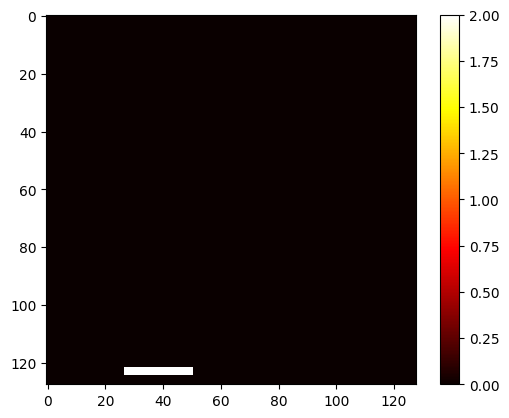

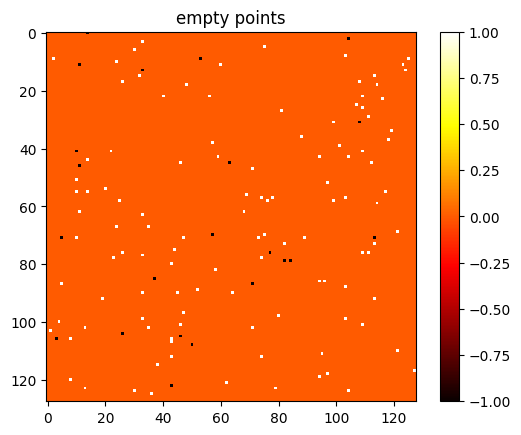

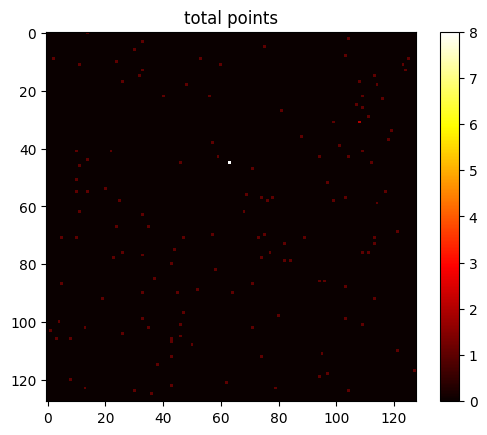

toall difference: 144
toall difference after modifying: 260
number of wrong filled pixels: 22
File 'temp/modified_level0.xml' moved successfully!
distance score: -121.0981140331734
Episode Score: -109.77811403317367, Loss: 6.593175411224365
##############################################


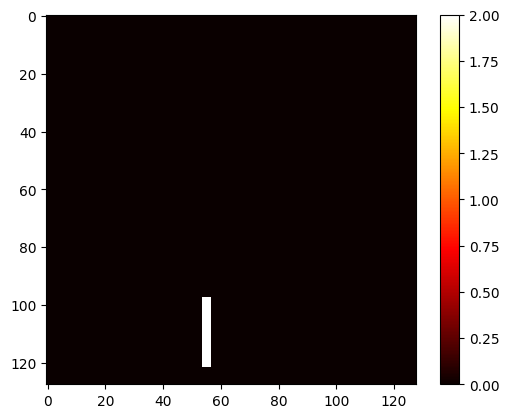

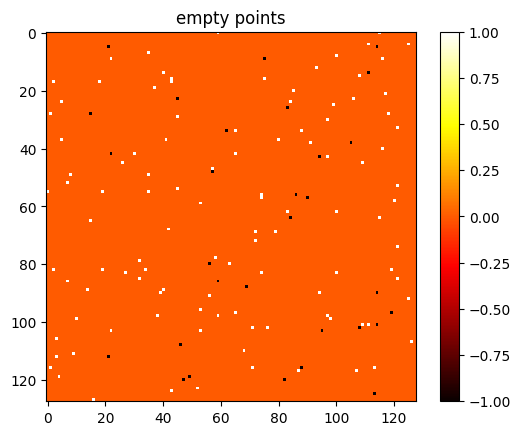

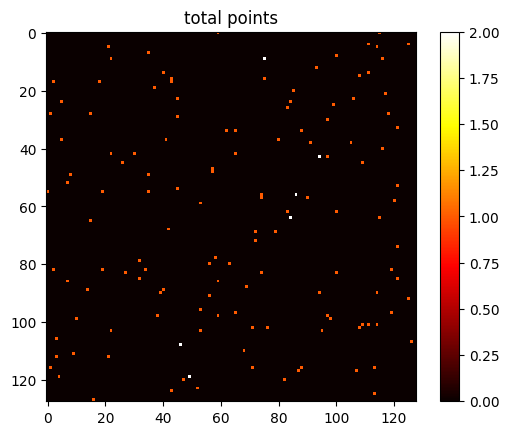

toall difference: 144
toall difference after modifying: 258
number of wrong filled pixels: 30
File 'temp/modified_level1.xml' moved successfully!
distance score: -118.03748660478836
Episode Score: -106.93748660478852, Loss: 6.153995037078857
##############################################


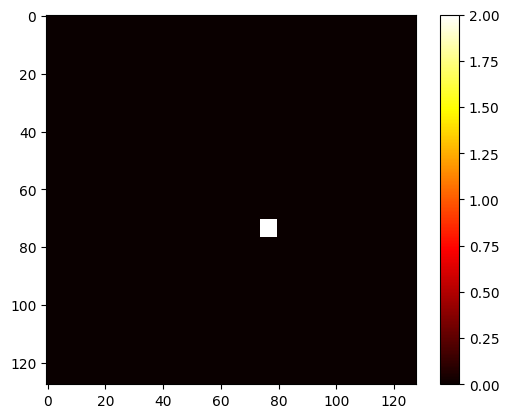

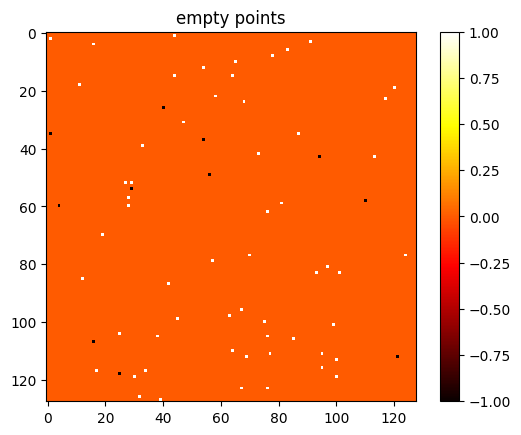

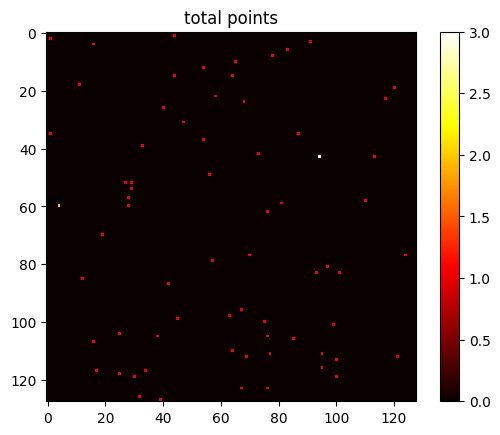

toall difference: 72
toall difference after modifying: 132
number of wrong filled pixels: 11
File 'temp/modified_level2.xml' moved successfully!
distance score: -55.21063154336417
Episode Score: -49.33063154336413, Loss: 7.238215923309326
##############################################


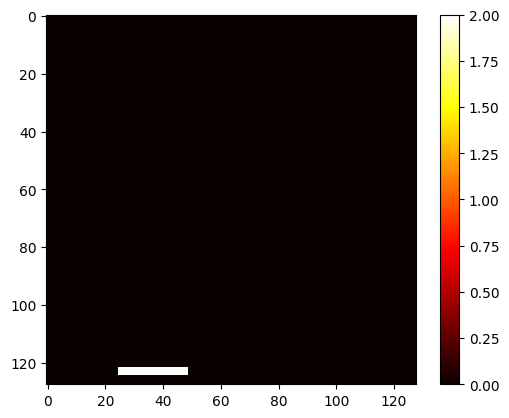

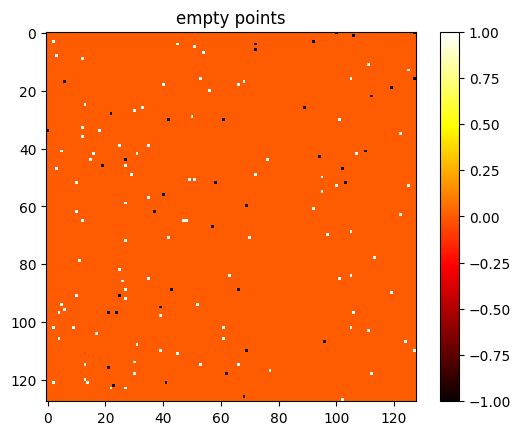

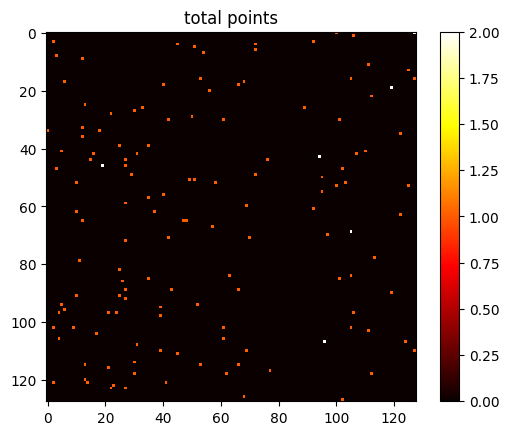

toall difference: 144
toall difference after modifying: 249
number of wrong filled pixels: 39
File 'temp/modified_level3.xml' moved successfully!
distance score: -109.58625921671118
Episode Score: -99.4762592167114, Loss: 5.4239702224731445
##############################################


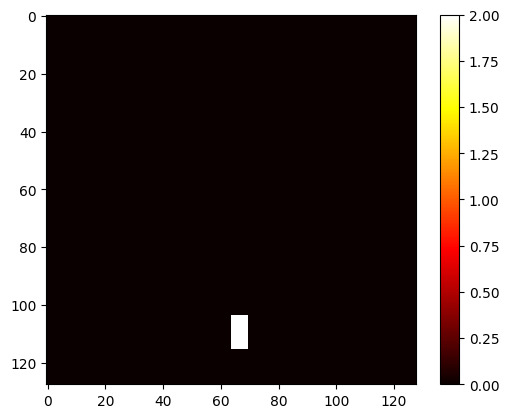

KeyboardInterrupt: 

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import copy

# Define a custom environment
class Environment:
    def __init__(self, map, max_step=10000):
        self.map = map  # Initialize the map
        self.state = copy.deepcopy(self.map)
        self.step_count = 0
        self.max_step = max_step
        self.done = False

    def reset(self):
        self.state = copy.deepcopy(self.map)
        self.step_count = 0
        self.done = False
        state_tensor = torch.tensor(self.state, dtype=torch.float32).flatten()
        return state_tensor

    def step(self, action):
        x, y, z = action  # Decompose the action into coordinates
        if self.state[x, y, z] == -1:
            self.state[x, y, z] = 1  # Place block if the spot is empty
            reward = 0.1  # Positive reward for placing a block
        else:
            reward = -0.01 # Negative reward if block is already there
        self.step_count += 1
        if self.step_count >= self.max_step:
            self.done = True
        return torch.tensor(self.state, dtype=torch.float32).flatten(), reward, self.done, {}

# PPO Model
class PPO(nn.Module):
    def __init__(self, input_size):
        super(PPO, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_pi = nn.Linear(128, input_size)
        self.fc_v = nn.Linear(128, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=0.03)
        # self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.99)
        self.data = []  # Initialize data list for storing transitions

    def pi(self, x, softmax_dim=0):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc_pi(x)
        prob = torch.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = zip(*self.data)
        self.data = []
        return torch.stack(s_lst), torch.tensor(a_lst, dtype=torch.long), torch.tensor(r_lst, dtype=torch.float), torch.stack(s_prime_lst), torch.tensor(done_lst, dtype=torch.float)

    def train_net(self, gamma=0.98, lmbda=0.95, eps_clip=0.2):
        s, a, r, s_prime, done = self.make_batch()
        td_target = r + gamma * self.v(s_prime) * (1 - done)
        delta = td_target - self.v(s)
        delta = delta.detach().numpy()
        advantage_lst = []
        advantage = 0.0
        for delta_t in delta[::-1]:
            advantage = gamma * lmbda * advantage + delta_t[0]
            advantage_lst.append([advantage])
        advantage_lst.reverse()
        advantage = torch.tensor(advantage_lst, dtype=torch.float)
        pi = self.pi(s, softmax_dim=1)
        pi_a = pi.gather(1, a.unsqueeze(1)).squeeze(1)
        ratio = torch.exp(torch.log(pi_a) - torch.log(pi_a.detach()))
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
        entropy = -(pi * torch.log(pi + 1e-5)).sum(1).mean()
        loss = -torch.min(surr1, surr2) + torch.nn.functional.smooth_l1_loss(self.v(s), td_target.detach()) - 0.01 * entropy
        self.optimizer.zero_grad()
        loss_mean = loss.mean()  # Compute mean loss
        loss_mean.backward()
        self.optimizer.step()
        # self.scheduler.step()
        return loss_mean  # Return the mean loss value
    
    
def main(iter_data, modified_iter_data):
    model = PPO(128*128*5)  # Initialize the PPO model
    score = 0.0
    counter = 0
    combined_dataset = tf.data.Dataset.zip((iter_data, modified_iter_data))
    distance_threshold = 40

    for (image_batch, data), (modified_image_batch, modified_data) in combined_dataset:
        
        original = image_batch[0].numpy()
        closest_score = 0.0
        score = 0.0
        env = Environment(modified_image_batch[0].numpy())  # Create environment from batch
        state = env.reset()  # Reset environment at the start of each batch
        diff, indices  = max_step_calc(original, env.state)
        plot_removed_blocks(indices)
        env.max_step = diff
        heatmap_dict = {}
        empty_point_dict = {}
        done = False
        while not done:
            prob = model.pi(state)  # Policy forward pass
            m = Categorical(prob)  # Distribution for sampling actions
            action_index = m.sample().item()  # Sample an action
            action = action_index // (128*5), (action_index % (128*5)) // 5, action_index % 5
            heatmap_dict[(action[0], action[1])] = heatmap_dict.get((action[0], action[1]), 0) + 1
            state_prime, reward, done, _ = env.step(action)  # Execute action in the environment
        
            model.put_data((state, action_index, reward, state_prime, done))  # Store data for training
            state = state_prime
            score += reward  # Update score
            if reward < 0:
                empty_point_dict[(action[0], action[1])] =  - 1
            else:
                empty_point_dict[(action[0], action[1])] = 1
            closest= find_closest_distance(action, pixel_list, distance_threshold)
            closest_score += closest
            score += closest
            loss = model.train_net()  # Train model
        
        plot_heatmap(empty_point_dict, title = "empty points")
        plot_heatmap(heatmap_dict, title = "total points")
        print(f"toall difference: {diff}")
        diff, _ = max_step_calc(original, env.state)
        print(f"toall difference after modifying: {diff}")
        wrong_filled = empty_point_dict.values()
        wrong_filled = list(filter(lambda x: x < 0, wrong_filled))
        print(f"number of wrong filled pixels: {len(wrong_filled)}")
        xml_path = xml_convert(original, env.state, "temp", counter, show_fig = True)
        final_path = move_file(xml_path, 'evaluation\\temp')
        # # if level is stable
        # if run_evaluation_xml_levels_one_by_one("temp", parameters[0]):
        #     print("Level is stable")
        #     score += 10
        # else:
        #     print("Level is not stable")
        #     score -= 10
        # os.remove(final_path)

        print(f"distance score: {closest_score}")
        print(f"Episode Score: {score}, Loss: {loss}")
        print("##############################################")
        counter += 1
        if counter % 20 == 0:
            print(f"Episode {counter} completed")
            
            if distance_threshold > 4:
                distance_threshold -= 2

if __name__ == '__main__':
    # Assume modified_iter_data is your dataset
    main(iter_data, modified_iter_data)
    # Save the model
    print("Model saved successfully")
    torch.save(model.state_dict(), 'ppo_model.pth')


In [ ]:
# Load the model
print("Loading ...")
model = PPO(128*128*5)  # Recreate the model
model.load_state_dict(torch.load('ppo_model.pth'))  # Load the saved parameters
model.eval()

In [ ]:
with torch.no_grad():  # Disable gradient computation for inference
    for image_batch, data in modified_iter_data:  # Assuming test data is provided in test_iter_data
        state = env.reset()  # Reset the environment
        done = False
        while not done:
            prob = model.pi(state)
            m = Categorical(prob)
            action_index = m.sample().item()
            action = (action_index // (128*128), (action_index % (128*128)) // 128, action_index % 5)  
            state_prime, reward, done, _ = env.step(action)
            state = state_prime
            if done:
                break


In [ ]:
# count = 0
# for idx in indices:
#     count += 1

#     row_idx, col_idx, channel_idx = idx[0], idx[1], idx[2]
#     original_value = tf.gather_nd(original, [idx])  # Get original value
#     modified = tf.tensor_scatter_nd_update(
#         modified, [[row_idx, col_idx, channel_idx]], original_value  # Update modified tensor
#     )



# print("Modified tensor with original values rewritten:")
# print(modified)